In [1]:
import paho.mqtt.client as paho
import numpy as np
import random
import json
import networkx as nx
from node import EpidemicGraph, TransitionDiagram, calc_R0
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime
from IPython.display import clear_output
# %matplotlib inline

In [2]:
broker_ip = '192.168.0.104'
broker_ip = 'localhost'
# broker_ip = '10.1.199.251'
# broker_ip = '10.101.6.111'
broker_ip = '10.101.21.2'
connflag = False

In [3]:
def plot(G, title='step_1', ns=1000, fs=12, lim=2, figsize=(5, 5)):
    pos = nx.get_node_attributes(G, 'position')
    ids = {i:i for i in range(N)}
    print('Total node number', N)

    s_a = [x for x,y in G.nodes(data=True) if y['state']=='S_a']
    s_s = [x for x,y in G.nodes(data=True) if y['state']=='S_s']
    i1_a = [x for x,y in G.nodes(data=True) if y['state']=='I1_a']
    i1_s = [x for x,y in G.nodes(data=True) if y['state']=='I1_s']
    i2_a = [x for x,y in G.nodes(data=True) if y['state']=='I2_a']
    i2_s = [x for x,y in G.nodes(data=True) if y['state']=='I2_s']


    fig = plt.figure(figsize=figsize)
    nx.draw_networkx_edges(G, pos, alpha=0.8)
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=s_a, node_color='#66ff99')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=s_s, node_color='#006600')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=i1_a, node_color='#ff6666')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=i1_s, node_color='#cc0000')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=i2_a, node_color='#3399ff')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=i2_s, node_color='#0000cc')
    nx.draw_networkx_labels(G, pos, ids, font_size=fs)

    plt.title(title)
    red_patch = mpatches.Patch(color='red', label='I1')
    blue_patch = mpatches.Patch(color='blue', label='I2')
    green_patch = mpatches.Patch(color='green', label='S')
    plt.legend(handles=[green_patch, red_patch, blue_patch])
    plt.xlim(0, lim)
    plt.ylim(0, lim)
    return plt, fig

In [4]:
mqttc = paho.Client()
counter = 0
N = 160
format_date = "%d %b %Y %H%M%S.%f"

def on_connect(client, userdata, flags, rc):
    global connflag
    #if connection is successful, rc value will be 0
    print("Connection returned result: " + str(rc) )
    connflag = True

def on_message(client, userdata, msg): 
    print("-t {} | -p {}".format(msg.topic, msg.payload.decode()) )
    
def on_state(client, userdata, msg): 
    global G, counter
    counter += 1
    name = datetime.now().strftime(format_date)
    js = json.loads(msg.payload.decode())
    G.node[js['pi_id']]['state'] = js['state']
#     if counter%N == 0:
#         plt, fig = plot(G, 'step {}'.format((counter-1)//N), **plt_set)
#         fig.savefig('figures/{}.png'.format(name))
#         plt.close()
    log = "-t {} | -p {}".format(msg.topic, msg.payload.decode())
    print( log)
    with open("log.txt", "a") as myfile:
        myfile.write("{},{}\n".format(name, log))
        
def on_finish(client, userdata, msg):  # on finish step
    global node_set
    log = "-t {} | -p {}".format(msg.topic, msg.payload.decode())
    with open("log_node_set.txt", "a") as myfile:
        myfile.write("{}\n".format(log))
    node_id = msg.payload.decode()
    node_set.discard(node_id)
    print(node_set)
#     with open("log_node_set.txt", "a") as myfile:
#         myfile.write("{},{}\n".format(node_set))
    if len(node_set) == 0:
#         mqttc.publish('next', 'dummy_msg', qos=2)
        node_set = {str(x) for x in range(N)}
#         clear_output(wait=True)

def on_finish_2(client, userdata, msg):  # on finish step
    global node_set
    log = "-t {} | -p {}".format(msg.topic, msg.payload.decode())
    with open("log_node_set.txt", "a") as myfile:
        myfile.write("{}\n".format(log))
    node_id_list = msg.payload.decode()
    node_set = {e for e in node_set if e not in node_id_list}
    print(node_set)
    if len(node_set) == 0:
#         mqttc.publish('nextstepflag', 'dummy_msg', qos=2)
        node_set = {str(x) for x in range(N)}
        clear_output(wait=True)
    
node_set = {str(x) for x in range(N)}
mqttc.on_connect = on_connect
mqttc.on_message = on_message
mqttc.message_callback_add("state", on_state)
mqttc.message_callback_add("finish", on_finish)
mqttc.message_callback_add("nextstep", on_finish_2)

mqttc.connect(broker_ip)
mqttc.loop_start()
mqttc.subscribe('state', 2)
mqttc.subscribe('nextstep', 2)
mqttc.subscribe('finish', 2)

Connection returned result: 0


(0, 3)

(1.1315473763020667, 6.295554475541461) (1, 0)
(1.1315473763020667, 6.295554475541461)
Total node number 160


/home/dd/.virtualenvs/pi/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


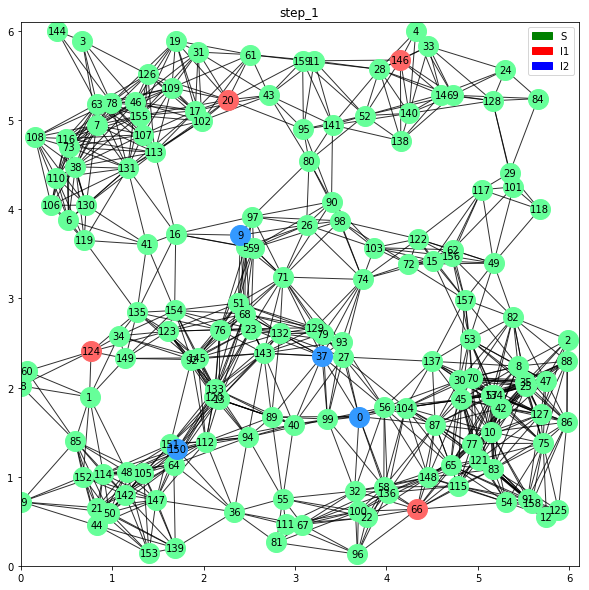

In [5]:
# 0.04 0.05|0.04 0.04|0.3 0.3  |0.05 0.2 |0.04 0.1   R1<1 R2<1    
# 0.04 0.15|0.04 0.04|0.25 0.07|0.06 0.12|0.05 0.15  R1<1 R2>1
# 0.25 0.05|0.04 0.04|0.25 0.5 |0.05 0.12|0.04 0.15  R1>1 R2<1
# 0.25 0.35|0.04 0.04|0.04 0.35|0.06 0.07|0.05 0.06  R1>1 R2>1
paramet = {    # R1<1 R2<1  
        'alpha': [0.04, 0.05], # infect rate 
        'mu': [0.04, 0.04], # sleep s 
        'gamma': [0.3, 0.3], # rec rate 
        'lambda': [0.05, 0.2], # sleep I1 
        'kappa': [0.04, 0.1] # sleep I2    % [I2_s -> I2_a, I2_a -> I2_s]
    }
paramet = {    # R1<1 R2<1  
        'alpha': [0.04, 0.15], # infect rate 
        'mu': [0.04, 0.04], # sleep s 
        'gamma': [0.25, 0.07], # rec rate 
        'lambda': [0.06, 0.12], # sleep I1 
        'kappa': [0.04, 0.15] # sleep I2    % [I2_s -> I2_a, I2_a -> I2_s]
    }
# paramet = {    # R1<1 R2<1  
#         'alpha': [0.04, 0.05], # infect rate 
#         'mu': [0.04, 0.04], # sleep s 
#         'gamma': [0.3, 0.3], # rec rate 
#         'lambda': [0.05, 0.2], # sleep I1 
#         'kappa': [0.04, 0.1] # sleep I2    % [I2_s -> I2_a, I2_a -> I2_s]
#     }
# paramet = {    # R1<1 R2<1  
#         'alpha': [0.04, 0.05], # infect rate 
#         'mu': [0.04, 0.04], # sleep s 
#         'gamma': [0.3, 0.3], # rec rate 
#         'lambda': [0.05, 0.2], # sleep I1 
#         'kappa': [0.04, 0.1] # sleep I2    % [I2_s -> I2_a, I2_a -> I2_s]
#     }
np.random.seed(315)  # structure
random.seed(6)       # infected
# N = 5
r = 1
number_subgraphs = 0


while number_subgraphs != 1:
    a = EpidemicGraph(N,r,paramet,I1_a=4, I2_a=4, grid_size=[6, 6], create=True) # net='Uniform Grid'
    number_subgraphs = len(list(nx.connected_component_subgraphs(a.G)))
    number_isolated_nodes = len(list(nx.isolates(a.G)))
    print(calc_R0(a.G, paramet), (number_subgraphs, number_isolated_nodes))

G = a.G
# G.node[0]['state'] = 'S_s'
print(calc_R0(a.G, paramet))
plt_set = {
    'ns': 400, 
    'fs': 10,
    'lim': 6.1, 
    'figsize': (10,10)
}
plt, fig = plot(G, **plt_set) #  ns=300, fs=6,lim=5
# plt.show()
fig.savefig('figures/_.png')

In [6]:
G.node[1]
node_set = {str(x) for x in range(N)}
msg_list = []
for node_id in range(N):
    neighbours = list(G[node_id])
    msg = {
        "id": node_id,
        "state": G.node[node_id]['state'],
        "neighbours": neighbours
    }
    msg_list.append(msg)
    print(msg)
    
mqttc.publish('init', json.dumps(msg_list))

{'id': 0, 'state': 'I2_a', 'neighbours': [27, 32, 37, 40, 56, 58, 87, 89, 93, 99, 104, 136]}
{'id': 1, 'state': 'S_a', 'neighbours': [18, 34, 48, 60, 85, 114, 124, 149, 152]}
{'id': 2, 'state': 'S_a', 'neighbours': [8, 25, 35, 47, 82, 86, 88, 127]}
{'id': 3, 'state': 'S_a', 'neighbours': [7, 46, 63, 78, 126, 144]}
{'id': 4, 'state': 'S_a', 'neighbours': [14, 28, 33, 69, 140, 146]}
{'id': 5, 'state': 'S_a', 'neighbours': [9, 16, 23, 26, 51, 59, 68, 71, 76, 97]}
{'id': 6, 'state': 'S_a', 'neighbours': [38, 41, 73, 106, 108, 110, 116, 119, 130, 131]}
{'id': 7, 'state': 'S_a', 'neighbours': [3, 38, 46, 63, 73, 78, 107, 108, 109, 110, 113, 116, 126, 130, 131, 155]}
{'id': 8, 'state': 'S_a', 'neighbours': [2, 10, 25, 30, 35, 42, 45, 47, 53, 57, 70, 75, 82, 86, 88, 127, 134, 137, 157]}
{'id': 9, 'state': 'I2_a', 'neighbours': [5, 16, 26, 51, 59, 68, 71, 97]}
{'id': 10, 'state': 'S_a', 'neighbours': [8, 25, 30, 35, 42, 45, 47, 54, 57, 65, 70, 75, 77, 83, 86, 87, 91, 104, 115, 121, 127, 134, 14

In [ ]:
# node_set = {str(x) for x in range(5)}
# # mqttc.publish('finish', '14', qos=2)
# unwanted = ['1','2','3','4','0'] # set()
# {e for e in node_set if e not in unwanted}


In [ ]:
# mqttc.loop_stop()

In [ ]:
# mqttc.publish('nextstep', 'dummy_msg', qos=2)

In [ ]:
# mqttc.publish('stop', 'dummy_msg', qos=2)

In [ ]:
# mqttc.publish('kill', 'process die', qos=2)

In [ ]:
# mqttc.publish('paramet', json.dumps(paramet), qos=2)

In [7]:
mqttc.publish('start', 'dummy_msg', qos=2)

-t state | -p {"step": 0, "pi_id": 64, "state": "S_a"}
-t state | -p {"step": 0, "pi_id": 65, "state": "S_a"}
-t state | -p {"step": 0, "pi_id": 66, "state": "I1_a"}
-t state | -p {"step": 0, "pi_id": 144, "state": "S_a"}
{'137', '87', '62', '68', '155', '39', '11', '63', '46', '125', '61', '92', '134', '157', '148', '72', '4', '37', '80', '147', '85', '3', '43', '60', '55', '67', '15', '38', '29', '0', '101', '65', '77', '112', '18', '124', '159', '115', '54', '51', '44', '88', '116', '74', '25', '69', '1', '50', '120', '53', '82', '42', '141', '107', '131', '26', '40', '128', '144', '91', '156', '30', '33', '73', '45', '100', '16', '97', '123', '79', '13', '98', '90', '94', '56', '21', '28', '95', '122', '99', '154', '64', '48', '114', '32', '57', '71', '35', '47', '70', '41', '58', '96', '111', '132', '140', '14', '86', '12', '27', '113', '105', '110', '17', '83', '76', '158', '9', '106', '130', '66', '139', '109', '146', '19', '102', '136', '149', '22', '118', '143', '104', '138', 

{'137', '87', '62', '68', '155', '39', '11', '63', '46', '125', '61', '92', '134', '157', '72', '4', '80', '147', '85', '3', '43', '60', '55', '67', '15', '38', '29', '0', '101', '65', '112', '18', '159', '115', '51', '44', '88', '116', '74', '25', '69', '1', '50', '120', '53', '82', '42', '141', '107', '131', '26', '40', '128', '144', '91', '156', '30', '33', '73', '45', '100', '16', '97', '123', '79', '13', '98', '90', '94', '56', '21', '28', '95', '122', '99', '154', '64', '48', '114', '32', '57', '71', '35', '47', '70', '41', '58', '96', '111', '132', '140', '14', '86', '12', '27', '113', '105', '110', '17', '83', '76', '158', '9', '106', '130', '139', '109', '19', '102', '136', '22', '118', '143', '104', '138', '6', '5', '152', '93', '78', '142', '23', '36', '24', '75', '117', '10', '119', '2', '108', '31', '121', '84', '133', '145', '103', '127', '59', '129', '52', '7', '89', '135', '20', '8', '126', '153', '81', '49', '151'}
-t state | -p {"state": "S_a", "pi_id": 48, "step": 0}

{'137', '87', '68', '39', '11', '63', '46', '125', '92', '134', '157', '4', '80', '147', '85', '3', '43', '60', '55', '67', '15', '38', '29', '0', '65', '112', '18', '115', '51', '44', '88', '116', '25', '69', '1', '50', '53', '82', '42', '141', '107', '131', '26', '128', '144', '91', '156', '30', '33', '73', '45', '100', '16', '97', '79', '98', '90', '94', '21', '28', '95', '99', '154', '114', '32', '57', '71', '35', '47', '70', '41', '58', '96', '111', '132', '140', '14', '86', '12', '27', '113', '110', '17', '83', '76', '158', '9', '106', '130', '139', '136', '22', '118', '143', '104', '138', '6', '5', '152', '93', '78', '142', '23', '36', '24', '75', '117', '10', '119', '2', '108', '31', '121', '84', '133', '145', '127', '59', '52', '7', '89', '135', '8', '153', '81', '49'}
{'137', '87', '68', '39', '11', '63', '46', '125', '92', '134', '157', '4', '80', '147', '85', '3', '43', '60', '55', '67', '15', '38', '29', '0', '65', '112', '18', '115', '51', '44', '88', '116', '25', '69', '

{'137', '87', '39', '46', '125', '92', '157', '134', '80', '85', '43', '55', '38', '29', '112', '18', '115', '51', '44', '88', '116', '25', '50', '53', '82', '42', '141', '107', '131', '26', '128', '144', '91', '156', '30', '33', '73', '45', '100', '16', '97', '98', '90', '94', '21', '95', '28', '32', '57', '71', '35', '47', '70', '41', '58', '96', '111', '132', '140', '14', '86', '27', '113', '110', '83', '76', '158', '106', '130', '136', '22', '118', '143', '104', '152', '78', '142', '23', '24', '75', '117', '10', '119', '108', '121', '84', '133', '127', '59', '81', '52', '89', '12', '49'}
{'152', '137', '87', '39', '78', '142', '49', '46', '50', '32', '57', '92', '71', '35', '134', '157', '47', '70', '41', '58', '96', '111', '132', '140', '14', '86', '117', '113', '53', '10', '110', '82', '80', '42', '141', '83', '76', '85', '107', '131', '158', '119', '43', '108', '55', '84', '106', '144', '130', '133', '91', '156', '30', '33', '38', '73', '45', '100', '59', '75', '81', '95', '136'

{'84', '87', '86', '89', '82', '80', '83', '85', '81', '88'}
-t state | -p {"state": "I2_a", "pi_id": 48, "step": 1}
-t state | -p {"state": null, "pi_id": 49, "step": 1}
-t state | -p {"state": "I2_a", "pi_id": 40, "step": 1}
-t state | -p {"state": null, "pi_id": 41, "step": 1}
-t state | -p {"state": null, "pi_id": 42, "step": 1}
-t state | -p {"state": null, "pi_id": 43, "step": 1}
-t state | -p {"state": null, "pi_id": 44, "step": 1}
-t state | -p {"state": null, "pi_id": 45, "step": 1}
-t state | -p {"state": null, "pi_id": 46, "step": 1}
-t state | -p {"state": null, "pi_id": 47, "step": 1}
{'84', '87', '86', '89', '82', '80', '83', '85', '81', '88'}
-t state | -p {"pi_id": 70, "step": 1, "state": null}
-t state | -p {"pi_id": 71, "step": 1, "state": null}
-t state | -p {"pi_id": 72, "step": 1, "state": "S_a"}
-t state | -p {"pi_id": 73, "step": 1, "state": null}
-t state | -p {"pi_id": 74, "step": 1, "state": "S_s"}
-t state | -p {"pi_id": 75, "step": 1, "state": null}
-t state

-t state | -p {"state": null, "pi_id": 42, "step": 2}
-t state | -p {"state": null, "pi_id": 43, "step": 2}
-t state | -p {"state": null, "pi_id": 44, "step": 2}
-t state | -p {"state": null, "pi_id": 45, "step": 2}
-t state | -p {"state": null, "pi_id": 46, "step": 2}
-t state | -p {"state": null, "pi_id": 47, "step": 2}
-t state | -p {"pi_id": 70, "step": 2, "state": null}
-t state | -p {"pi_id": 71, "step": 2, "state": null}
-t state | -p {"pi_id": 72, "step": 2, "state": "S_a"}
-t state | -p {"pi_id": 73, "step": 2, "state": null}
-t state | -p {"pi_id": 74, "step": 2, "state": "S_a"}
-t state | -p {"pi_id": 75, "step": 2, "state": null}
-t state | -p {"pi_id": 76, "step": 2, "state": null}
-t state | -p {"pi_id": 77, "step": 2, "state": "I1_a"}
-t state | -p {"pi_id": 78, "step": 2, "state": null}
-t state | -p {"pi_id": 79, "step": 2, "state": "S_a"}
{'84', '87', '86', '89', '82', '80', '83', '85', '81', '88'}
{'84', '87', '86', '89', '82', '80', '83', '85', '81', '88'}
{'84', '8

-t state | -p {"pi_id": 71, "step": 3, "state": null}
-t state | -p {"pi_id": 72, "step": 3, "state": "S_a"}
-t state | -p {"pi_id": 73, "step": 3, "state": null}
-t state | -p {"pi_id": 74, "step": 3, "state": "S_a"}
-t state | -p {"pi_id": 75, "step": 3, "state": null}
-t state | -p {"pi_id": 76, "step": 3, "state": null}
-t state | -p {"pi_id": 77, "step": 3, "state": "I1_a"}
-t state | -p {"pi_id": 78, "step": 3, "state": null}
-t state | -p {"pi_id": 79, "step": 3, "state": "I2_a"}
{'84', '87', '86', '89', '82', '80', '83', '85', '81', '88'}
{'84', '87', '86', '89', '82', '80', '83', '85', '81', '88'}
{'84', '87', '86', '89', '82', '80', '83', '85', '81', '88'}
{'84', '87', '86', '89', '82', '80', '83', '85', '81', '88'}
{'84', '87', '86', '89', '82', '80', '83', '85', '81', '88'}
{'84', '87', '86', '89', '82', '80', '83', '85', '81', '88'}
{'84', '87', '86', '89', '82', '80', '83', '85', '81', '88'}
{'84', '87', '86', '89', '82', '80', '83', '85', '81', '88'}
-t state | -p {"step

-t state | -p {"step": 4, "state": "I1_a", "pi_id": 20}
-t state | -p {"step": 4, "state": null, "pi_id": 21}
-t state | -p {"step": 4, "state": "I1_a", "pi_id": 22}
-t state | -p {"step": 4, "state": null, "pi_id": 23}
-t state | -p {"step": 4, "state": null, "pi_id": 24}
-t state | -p {"step": 4, "state": null, "pi_id": 25}
-t state | -p {"step": 4, "state": null, "pi_id": 26}
-t state | -p {"step": 4, "state": null, "pi_id": 27}
-t state | -p {"step": 4, "state": null, "pi_id": 28}
-t state | -p {"step": 4, "state": null, "pi_id": 29}
-t state | -p {"state": "S_a", "pi_id": 48, "step": 4}
-t state | -p {"state": null, "pi_id": 49, "step": 4}
-t state | -p {"state": "I2_a", "pi_id": 40, "step": 4}
-t state | -p {"state": null, "pi_id": 41, "step": 4}
-t state | -p {"state": null, "pi_id": 42, "step": 4}
-t state | -p {"state": null, "pi_id": 43, "step": 4}
-t state | -p {"state": null, "pi_id": 44, "step": 4}
-t state | -p {"state": null, "pi_id": 45, "step": 4}
-t state | -p {"state

-t state | -p {"state": null, "pi_id": 49, "step": 5}
-t state | -p {"state": "I2_a", "pi_id": 40, "step": 5}
-t state | -p {"state": null, "pi_id": 41, "step": 5}
-t state | -p {"state": null, "pi_id": 42, "step": 5}
-t state | -p {"state": null, "pi_id": 43, "step": 5}
-t state | -p {"state": null, "pi_id": 44, "step": 5}
-t state | -p {"state": null, "pi_id": 45, "step": 5}
-t state | -p {"state": null, "pi_id": 46, "step": 5}
-t state | -p {"state": null, "pi_id": 47, "step": 5}
-t state | -p {"pi_id": 70, "step": 5, "state": null}
-t state | -p {"pi_id": 71, "step": 5, "state": null}
-t state | -p {"pi_id": 72, "step": 5, "state": "S_a"}
-t state | -p {"pi_id": 73, "step": 5, "state": null}
-t state | -p {"pi_id": 74, "step": 5, "state": "S_a"}
-t state | -p {"pi_id": 75, "step": 5, "state": null}
-t state | -p {"pi_id": 76, "step": 5, "state": null}
-t state | -p {"pi_id": 77, "step": 5, "state": "I1_a"}
-t state | -p {"pi_id": 78, "step": 5, "state": null}
-t state | -p {"pi_id"

-t state | -p {"pi_id": 92, "state": null, "step": 6}
-t state | -p {"pi_id": 93, "state": "I2_a", "step": 6}
-t state | -p {"pi_id": 94, "state": null, "step": 6}
-t state | -p {"pi_id": 95, "state": null, "step": 6}
-t state | -p {"pi_id": 70, "step": 6, "state": null}
-t state | -p {"pi_id": 71, "step": 6, "state": null}
-t state | -p {"pi_id": 72, "step": 6, "state": "S_a"}
-t state | -p {"pi_id": 73, "step": 6, "state": null}
-t state | -p {"pi_id": 74, "step": 6, "state": "S_a"}
-t state | -p {"pi_id": 75, "step": 6, "state": null}
-t state | -p {"pi_id": 76, "step": 6, "state": null}
-t state | -p {"pi_id": 77, "step": 6, "state": "I1_a"}
-t state | -p {"pi_id": 78, "step": 6, "state": null}
-t state | -p {"pi_id": 79, "step": 6, "state": "I2_a"}
{'84', '87', '86', '89', '82', '80', '83', '85', '81', '88'}
{'84', '87', '86', '89', '82', '80', '83', '85', '81', '88'}
-t state | -p {"state": "I2_a", "pi_id": 48, "step": 6}
-t state | -p {"state": null, "pi_id": 49, "step": 6}
-t s

{'84', '87', '86', '89', '82', '80', '83', '85', '81', '88'}
{'84', '87', '86', '89', '82', '80', '83', '85', '81', '88'}
{'84', '87', '86', '89', '82', '80', '83', '85', '81', '88'}
{'84', '87', '86', '89', '82', '80', '83', '85', '81', '88'}
{'84', '87', '86', '89', '82', '80', '83', '85', '81', '88'}
{'84', '87', '86', '89', '82', '80', '83', '85', '81', '88'}
-t state | -p {"step": 7, "state": "I1_a", "pi_id": 20}
-t state | -p {"step": 7, "state": null, "pi_id": 21}
-t state | -p {"step": 7, "state": "I1_a", "pi_id": 22}
-t state | -p {"step": 7, "state": null, "pi_id": 23}
-t state | -p {"step": 7, "state": null, "pi_id": 24}
-t state | -p {"step": 7, "state": null, "pi_id": 25}
-t state | -p {"step": 7, "state": null, "pi_id": 26}
-t state | -p {"step": 7, "state": null, "pi_id": 27}
-t state | -p {"step": 7, "state": null, "pi_id": 28}
-t state | -p {"step": 7, "state": null, "pi_id": 29}
-t state | -p {"step": 7, "pi_id": 100, "state": null}
-t state | -p {"step": 7, "pi_id": 

-t state | -p {"state": "I2_a", "step": 8, "pi_id": 150}
-t state | -p {"state": "I2_a", "step": 8, "pi_id": 151}
-t state | -p {"state": null, "step": 8, "pi_id": 152}
-t state | -p {"state": "I2_a", "step": 8, "pi_id": 153}
-t state | -p {"state": "I1_a", "step": 8, "pi_id": 154}
-t state | -p {"state": "I1_a", "step": 8, "pi_id": 155}
-t state | -p {"state": null, "step": 8, "pi_id": 156}
-t state | -p {"state": null, "step": 8, "pi_id": 157}
-t state | -p {"state": null, "step": 8, "pi_id": 158}
-t state | -p {"state": "I1_a", "step": 8, "pi_id": 159}
{'84', '87', '86', '89', '82', '80', '83', '85', '81', '88'}
{'84', '87', '86', '89', '82', '80', '83', '85', '81', '88'}
{'84', '87', '86', '89', '82', '80', '83', '85', '81', '88'}
{'84', '87', '86', '89', '82', '80', '83', '85', '81', '88'}
{'84', '87', '86', '89', '82', '80', '83', '85', '81', '88'}
-t state | -p {"step": 8, "state": null, "pi_id": 50}
-t state | -p {"step": 8, "state": null, "pi_id": 51}
-t state | -p {"step": 8,

In [ ]:
# mqttc.reinitialise()
# mqttc.loop_start()
# msg = {
#                 'step': 22, 
#                 'pi_id': 27,  # 27
#                 'state': 'S_a'
#             }
# mqttc.publish('27', json.dumps(msg), 2) 

In [ ]:
# a = ['python node_{0}/pi_main_2.py node_{0}'.format(i) for i in range(0, 5)]
# str.join(' & ', a)

# with open('node_id.json') as f:
#     my_id_list = json.load(f)

# my_nodes = {node_id: node_id**2 for node_id in my_id_list}
# node_list = list(range(5, 10))
# node_list


In [11]:
N = 10
wait_broadcast_finish_flag = [False for x in range(N)]
wait_broadcast_finish_flag[0] = True
all(wait_broadcast_finish_flag)

False